In [12]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('../Data/dataset_1000_minimum_reviews.csv', index_col='Unnamed: 0')
df = data[['time', 'movie_id', 'user_id', 'binary_rating']]
df.head()

,time,movie_id,user_id,binary_rating
0,0,1961,1107,1
1,1,1259,1545,0
2,2,595,3304,1
3,3,260,5448,0
4,4,1784,3829,0


In [4]:
def policy_evaluator_moss(dataframe):
    # We stock the payoffs in a list
    payoffs = []
    # We pull each arm once to initialize history
    history = dataframe.groupby('movie_id').first()
    arms = dataframe['movie_id'].unique()
    n_arms = len(arms)
    history['movie_id'] = history.index
    # We drop the rows associated to the initial pull
    rows_to_drop = history['time']
    history['time'] = 0
    history.reset_index(drop=True, inplace=True)
    history = history[dataframe.columns]
    dataframe_copy = dataframe.copy()
    dataframe_copy.drop(rows_to_drop, inplace=True)
    dataframe_copy.reset_index(drop=True, inplace=True)
    dataframe_copy['time'] = dataframe_copy.index
    # We create a dict containing all the movies ID and their corresponding number of pulls
    s = {}
    n = len(dataframe_copy)
    for t in range(1, len(dataframe_copy) + 1):
        # We get t-th row of our dataframe
        t_event = dataframe_copy[t-1:t]
        # We get the recommendation of our algorithm
        objective_function = {}
        for k in arms:
            objective_function[k] = history[history['movie_id'] == k]['binary_rating'].mean() + np.sqrt( max(np.log( n / (n_arms * t ) ), 0) / t )
        
        arm_chosen = max(objective_function, key=objective_function.get)

        s[arm_chosen] += 1

        if arm_chosen == t_event['movie_id'].iloc[0]:
            history.loc[len(history)] = t_event.iloc[0].to_list()
            payoffs.append(t_event['binary_rating'].iloc[0])

    return payoffs

In [22]:
def policy_evaluator_moss_random(dataframe):
    # We stock the payoffs in a list
    payoffs = []
    # We pull each arm once to initialize history
    history = dataframe.groupby('movie_id').first()
    arms = dataframe['movie_id'].unique()
    n_arms = len(arms)
    history['movie_id'] = history.index
    # We drop the rows associated to the initial pull
    rows_to_drop = history['time']
    history['time'] = 0
    history.reset_index(drop=True, inplace=True)
    history = history[dataframe.columns]
    dataframe_copy = dataframe.copy()
    dataframe_copy.drop(rows_to_drop, inplace=True)
    dataframe_copy.reset_index(drop=True, inplace=True)
    dataframe_copy['time'] = dataframe_copy.index
    n = len(dataframe_copy)
    for t in range(1, len(dataframe_copy) + 1):
        # We get t-th row of our dataframe
        t_event = dataframe_copy[t-1:t]
        # We get the recommendation of our algorithm
        # The groupby allows to get s without adding a dictionary. It also allows us to not have a loop over each arm.
        objective_function = history[['movie_id', 'binary_rating']].groupby('movie_id').agg({'binary_rating': ['mean', 'count']})
        objective_function.columns = ['mean', 'count']
        objective_function['value'] = objective_function['mean'] + np.sqrt( max(np.log( n / (n_arms * t ) ), 0) / t )
        
        # We check if there's only one argmax (one arm that maximizes the objective_function)
        max_value = objective_function['value'].max()
        if len(objective_function[objective_function['value'] == max_value]) == 1:
            
            arm_chosen = objective_function['value'].idxmax() # Our movies id are the index of our dataframe
        # If several arms are maximizing the objective function, we pick one randomly
        else:
            list_of_arms = objective_function[objective_function['value'] == objective_function['value'].max()].index.to_list()
            arm_chosen = random.choice(list_of_arms)

        if arm_chosen == t_event['movie_id'].iloc[0]:
            history.loc[len(history)] = t_event.iloc[0].to_list()
            payoffs.append(t_event['binary_rating'].iloc[0])

    return payoffs

In [23]:
def policy_evaluator_moss_min(dataframe):
    # We stock the payoffs in a list
    payoffs = []
    # We pull each arm once to initialize history
    history = dataframe.groupby('movie_id').first()
    arms = dataframe['movie_id'].unique()
    n_arms = len(arms)
    history['movie_id'] = history.index
    # We drop the rows associated to the initial pull
    rows_to_drop = history['time']
    history['time'] = 0
    history.reset_index(drop=True, inplace=True)
    history = history[dataframe.columns]
    dataframe_copy = dataframe.copy()
    dataframe_copy.drop(rows_to_drop, inplace=True)
    dataframe_copy.reset_index(drop=True, inplace=True)
    dataframe_copy['time'] = dataframe_copy.index
    n = len(dataframe_copy)
    for t in range(1, len(dataframe_copy) + 1):
        # We get t-th row of our dataframe
        t_event = dataframe_copy[t-1:t]
        # We get the recommendation of our algorithm
        # The groupby allows to get s without adding a dictionary. It also allows us to not have a loop over each arm.
        objective_function = history[['movie_id', 'binary_rating']].groupby('movie_id').agg({'binary_rating': ['mean', 'count']})
        objective_function.columns = ['mean', 'count']
        objective_function['value'] = objective_function['mean'] + np.sqrt( max(np.log( n / (n_arms * t ) ), 0) / t )
        
        # Even if several arms are maximizing the mean, we choose the arm with lowest id thanks to argmax
        arm_chosen = objective_function['value'].idxmax() # Our movies id are the index of our dataframe

        if arm_chosen == t_event['movie_id'].iloc[0]:
            history.loc[len(history)] = t_event.iloc[0].to_list()
            payoffs.append(t_event['binary_rating'].iloc[0])

    return payoffs

In [18]:
payoffs1 = policy_evaluator_moss_random(df, 1.35)

In [19]:
payoffs2 = policy_evaluator_moss_min(df, 1.35)

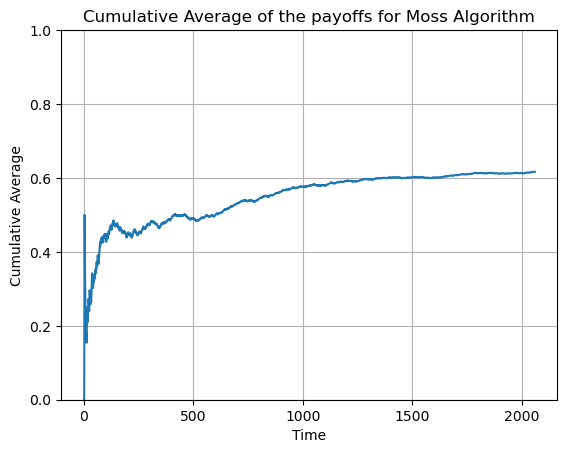

In [25]:
cumulative_average = np.cumsum(payoffs1) / np.arange(1, len(payoffs1)+1)

plt.plot(cumulative_average)
plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for Moss Algorithm")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

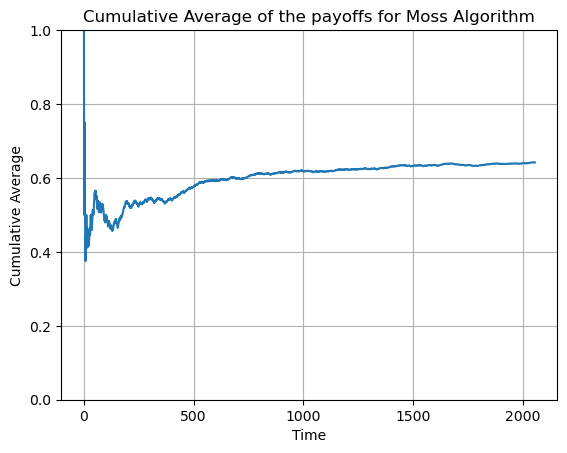

In [24]:
cumulative_average = np.cumsum(payoffs2) / np.arange(1, len(payoffs2)+1)

plt.plot(cumulative_average)
plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for Moss Algorithm")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

No differences between both algorithm, we thus decide to keep the argmin. It looks like with more data, our cumulative reward would still increase and so still hasn't converged totally.